In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir


In [2]:
data_path = ['fd-1kpc-9.6sm-0-overlaid.csv/npz_subevents']
file_list = []
for path_ in data_path:
    for file_ in listdir(path_):
        file_list.append(os.path.join(path_, file_))
file_list.sort()

In [3]:
'''siglist=[]
for items in file_list:
    data = np.load( items )
    siglist.append(data['sig'])

sigindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==1]
bkgindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==0]
print(len(sigindex))
print(len(bkgindex))'''

"siglist=[]\nfor items in file_list:\n    data = np.load( items )\n    siglist.append(data['sig'])\n\nsigindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==1]\nbkgindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==0]\nprint(len(sigindex))\nprint(len(bkgindex))"

In [3]:
# image size
z_size = 448
xy_size = 384


def shadow(pixel_loc, matrix, step=1):
    for i in range( np.max([pixel_loc[0]-step, 0]), np.min([pixel_loc[0]+step+1, matrix.shape[0]]) ):
        for j in range( np.max([pixel_loc[1]-step, 0]), np.min([pixel_loc[1]+step+1, matrix.shape[1]])):
            matrix[i, j] = 1
    # in place modification of the matrix

shadowstep=10
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, file_list_):
        self.file_list = file_list_
        self.len = len(file_list_)
        
    def __getitem__(self, index):
        file_name = self.file_list[index]
        data = np.load( file_name ) 
        labelxz = data['labelxz']
        labelyz = data['labelyz']
        labelxzimg=np.zeros((z_size, xy_size), dtype=int)
        labelyzimg=np.zeros((z_size, xy_size), dtype=int)
        for i in range(labelxz.shape[0]):
            shadow(labelxz[i,:], labelxzimg, step=shadowstep)
        for i in range(labelyz.shape[0]):
            shadow(labelyz[i,:], labelyzimg, step=shadowstep)

        return torch.from_numpy(data['imxz'][:, :, :]).to(torch.float), \
                torch.from_numpy(data['imyz'][:, :, :]).to(torch.float), \
                torch.from_numpy(labelxzimg).to(torch.long), \
                torch.from_numpy(labelyzimg).to(torch.long)
        
    def __len__(self):
        return self.len

mydataset = MyDataset(file_list)
batch_size_train = 4
batch_size_test = 2


train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)                

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.unpool=nn.Upsample(scale_factor=2, mode='nearest')

        self.conv1_1 = nn.Conv2d(2, 64, 3) 
        self.conv1_2 = nn.Conv2d(2, 64, 3) 
        
        self.conv2_1 = nn.Conv2d(64, 128, 3)
        self.conv2_2 = nn.Conv2d(64, 128, 3)

        self.conv3_1 = nn.Conv2d(128, 256, 3)
        self.conv3_2 = nn.Conv2d(128, 256, 3) 

        self.conv4_1 = nn.Conv2d(256, 256, 3)
        self.conv4_2 = nn.Conv2d(256, 256, 3)

        self.conv5_1 = nn.Conv2d(256, 512, 3)
        self.conv5_2 = nn.Conv2d(256, 512, 3)

        self.conv6_1 = nn.Conv2d(512, 512, 3)
        self.conv6_2 = nn.Conv2d(512, 512, 3)

        self.conv7_1 = nn.Conv2d(512, 512, 3)
        self.conv7_2 = nn.Conv2d(512, 512, 3)

        self.conv8_1 = nn.Conv2d(512, 512, 3)
        self.conv8_2 = nn.Conv2d(512, 512, 3)

        self.convtrans1_1 = nn.ConvTranspose2d(1024, 512, 2)
        self.convtrans1_2 = nn.ConvTranspose2d(1024, 512, 2)

        self.convtrans2_1 = nn.ConvTranspose2d(512, 512, 2)
        self.convtrans2_2 = nn.ConvTranspose2d(512, 512, 2)

        self.convtrans3_1 = nn.ConvTranspose2d(512, 256, 2)
        self.convtrans3_2 = nn.ConvTranspose2d(512, 256, 2)

        self.convtrans4_1 = nn.ConvTranspose2d(256, 256, 2)
        self.convtrans4_2 = nn.ConvTranspose2d(256, 256, 2)

        self.convtrans5_1 = nn.ConvTranspose2d(256, 128, 2)
        self.convtrans5_2 = nn.ConvTranspose2d(256, 128, 2)

        self.convtrans6_1 = nn.ConvTranspose2d(128, 64, 3)
        self.convtrans6_2 = nn.ConvTranspose2d(128, 64, 3)

        self.convtrans7_1 = nn.ConvTranspose2d(64, 2, 2)
        self.convtrans7_2 = nn.ConvTranspose2d(64, 2, 2)

        self.convtrans8_1 = nn.ConvTranspose2d(2, 2, 3)
        self.convtrans8_2 = nn.ConvTranspose2d(2, 2, 3)



    def forward(self, x1, x2):
        #print(x1.shape, x2.shape)
        # x1, x2 shape: (896, 384)      channel = 1
        x1_origin = x1
        x2_origin = x2

        x1 = self.pool(F.relu(self.conv1_1(x1)))    # shape: (448, 384)->(446, 382)->(223, 191)

        x1 = self.pool(F.relu(self.conv2_1(x1)))    # shape: (223, 191)->(221, 189)->(111, 95)

        x1 = F.relu(self.conv3_1(x1))               # shape: (111, 95)->(109, 93)
        x1 = self.pool(F.relu(self.conv4_1(x1)))    # shape: (109, 93)->(107, 91)->(54, 46)

        x1 = F.relu(self.conv5_1(x1))               # shape: (54, 46)->(52, 44)
        x1 = self.pool(F.relu(self.conv6_1(x1)))    # shape: (52, 44)->(50, 42)->(25, 21)

        x1 = F.relu(self.conv7_1(x1))               # shape: (25, 21)->(23, 19)
        x1 = self.pool(F.relu(self.conv8_1(x1)))    # shape: (23, 19)->(21, 17)->(11, 9)


        x2 = self.pool(F.relu(self.conv1_2(x2)))    # shape: (448, 384)->(446, 382)->(223, 191)
        
        x2 = self.pool(F.relu(self.conv2_2(x2)))    # shape: (223, 191)->(221, 189)->(111, 95)

        x2 = F.relu(self.conv3_2(x2))               # shape: (111, 95)->(109, 93)
        x2 = self.pool(F.relu(self.conv4_2(x2)))    # shape: (109, 93)->(107, 91)->(54, 46)

        x2 = F.relu(self.conv5_2(x2))               # shape: (54, 46)->(52, 44)
        x2 = self.pool(F.relu(self.conv6_2(x2)))    # shape: (52, 44)->(50, 42)->(25, 21)

        x2 = F.relu(self.conv7_2(x2))               # shape: (25, 21)->(23, 19)
        x2 = self.pool(F.relu(self.conv8_2(x2)))    # shape: (23, 19)->(21, 17)->(11, 9)

        x_all = torch.cat((x1, x2), 1)

        x1reco = self.unpool(F.relu(self.convtrans1_1(x_all)))    # shape: (11, 9)->(24, 20)
        x1reco = F.relu(self.convtrans2_1(x1reco))    # shape: (24, 20)->(25, 21)

        x1reco = self.unpool(F.relu(self.convtrans3_1(x1reco)))    # shape: (25, 21)->(52, 44)
        x1reco = F.relu(self.convtrans4_1(x1reco))    # shape: (52, 44)->(53, 45)

        x1reco = self.unpool(F.relu(self.convtrans5_1(x1reco)))    # shape: (53, 45)->(108, 92)
        x1reco = F.relu(self.convtrans6_1(x1reco))    # shape: (108, 92)->(109, 93)

        x1reco = self.unpool(F.relu(self.convtrans7_1(x1reco)))    # shape: (109, 93)->(220, 188)
        x1reco = self.unpool(F.relu(self.convtrans8_1(x1reco)))    # shape: (220, 188)->(442, 378)


        x2reco = self.unpool(F.relu(self.convtrans1_2(x_all)))    # shape: (11, 9)->(24, 20)
        x2reco = F.relu(self.convtrans2_2(x2reco))    # shape: (24, 20)->(25, 21)

        x2reco = self.unpool(F.relu(self.convtrans3_2(x2reco)))    # shape: (25, 21)->(52, 44)
        x2reco = F.relu(self.convtrans4_2(x2reco))    # shape: (52, 44)->(53, 45)

        x2reco = self.unpool(F.relu(self.convtrans5_2(x2reco)))    # shape: (53, 45)->(108, 92)
        x2reco = F.relu(self.convtrans6_2(x2reco))    # shape: (108, 92)->(109, 93)

        x2reco = self.unpool(F.relu(self.convtrans7_2(x2reco)))    # shape: (109, 93)->(220, 188)
        x2reco = self.unpool(F.relu(self.convtrans8_2(x2reco)))    # shape: (220, 188)->(442, 378)
        
        x1reco=torch.squeeze(x1reco)
        x2reco=torch.squeeze(x2reco)
        #print(x1reco.shape, x2reco.shape)
        return x1reco+x1_origin, x2reco+x2_origin
net=Net().cuda()

In [5]:
aout, _=net.forward(mydataset.__getitem__(0)[0][None, :, :, :].cuda(), mydataset.__getitem__(0)[1][None, :, :, :].cuda())
aout.shape

C:\Users\swyx2\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 2, 448, 384])

In [7]:
#criterion(aout, mydataset.__getitem__(0)[2][None, :, :].cuda())

In [6]:
aout.shape

torch.Size([1, 2, 448, 384])

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 200]).cuda())
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [8]:
sum(p.numel() for p in net.parameters())

26718288

In [9]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [15]:
# Training
loss_list = []
alpha=0.2
epochs = 100


accuracy_list = []

for i in range(epochs):
    net.train()
    for (batch_idx, batch) in enumerate(trainloader):
        XZ_train_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_train_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        labelmap_xz_train_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU
        labelmap_yz_train_batch = batch[3].cuda() # remove .cuda() if you don't have a GPU

        Netoutxz, Netoutyz = net.forward(XZ_train_batch, YZ_train_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout))
        #print(Netoutxz.shape, Netoutyz.shape)
        #print(labelmap_xz_train_batch.shape, labelmap_yz_train_batch.shape)

        loss = criterion(Netoutxz, labelmap_xz_train_batch)+criterion(Netoutyz, labelmap_yz_train_batch) # classification loss
        
        # Zero the gradients before running the backward pass.
        optimizer.zero_grad() 
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0 or True:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.6f}".format(i, batch_idx, loss))
    
    net.eval() # begin testing
    preds = np.array([])
    reals = np.array([])

    with torch.no_grad():
        for (batch_idx, batch) in enumerate(testloader):
            XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
            YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
            labelmap_xz_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU
            labelmap_yz_test_batch = batch[3].cuda() # remove .cuda() if you don't have a GPU


            Netoutxz_, Netoutyz_ = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.


            predictionxz=F.softmax(Netoutxz, dim=1).cpu().numpy()
            predictionyz=F.softmax(Netoutyz, dim=1).cpu().numpy()
            
            preds=np.concatenate((preds, np.sum(predictionxz, axis=(1,2,3) )))
            reals=np.concatenate((reals, np.sum(predictionyz, axis=(1,2,3) )))
        preds=np.array(preds)
        reals=np.array(reals)
        accuracy=np.sum((preds-reals)**2)
        accuracy_list.append(accuracy)
        print("Squared Error: {}".format(accuracy))


Epoch: 0, batch: 0 Loss: 0.744705
Epoch: 0, batch: 1 Loss: 0.459503
Epoch: 0, batch: 2 Loss: 0.459997
Epoch: 0, batch: 3 Loss: 0.458179
Epoch: 0, batch: 4 Loss: 0.194114
Epoch: 0, batch: 5 Loss: 0.856371
Epoch: 0, batch: 6 Loss: 0.193540
Epoch: 0, batch: 7 Loss: 1.397960
Epoch: 0, batch: 8 Loss: 0.193219
Epoch: 0, batch: 9 Loss: 0.406471
Epoch: 0, batch: 10 Loss: 0.192941
Epoch: 0, batch: 11 Loss: 0.192420
Epoch: 0, batch: 12 Loss: 0.192286
Epoch: 0, batch: 13 Loss: 0.191459
Epoch: 0, batch: 14 Loss: 0.190925
Epoch: 0, batch: 15 Loss: 0.190265
Epoch: 0, batch: 16 Loss: 0.189437
Epoch: 0, batch: 17 Loss: 1.114248
Epoch: 0, batch: 18 Loss: 0.188158
Epoch: 0, batch: 19 Loss: 0.716238
Epoch: 0, batch: 20 Loss: 0.476771
Epoch: 0, batch: 21 Loss: 0.448384
Epoch: 0, batch: 22 Loss: 0.185702
Epoch: 0, batch: 23 Loss: 0.390647
Epoch: 0, batch: 24 Loss: 0.184443
Epoch: 0, batch: 25 Loss: 0.183722
Epoch: 0, batch: 26 Loss: 0.467227
Epoch: 0, batch: 27 Loss: 0.877220
Epoch: 0, batch: 28 Loss: 0.94

KeyboardInterrupt: 

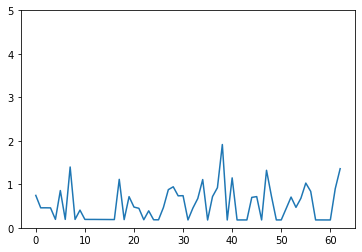

In [20]:
loss_listnp=[i.cpu().detach().numpy() for i in loss_list]
plt.plot(loss_listnp)
plt.ylim(0, 5)
plt.show()

In [28]:
net.eval() # begin testing
preds = np.array([])
reals = np.array([])

with torch.no_grad():
    for (batch_idx, batch) in enumerate(testloader):
        XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        labelmap_xz_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU
        labelmap_yz_test_batch = batch[3].cuda() # remove .cuda() if you don't have a GPU


        Netoutxz_, Netoutyz_ = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.

        loss = criterion(Netoutxz_, labelmap_xz_test_batch)+criterion(Netoutyz_, labelmap_yz_test_batch) # classification loss

        predictionxz=F.softmax(Netoutxz, dim=1).cpu().numpy()
        realxz=labelmap_xz_test_batch.cpu().numpy()
        
        preds=np.concatenate((preds, np.sum(predictionxz, axis=(1,2,3) )))
        reals=np.concatenate((reals, np.sum(realxz, axis=(1,2) )))
    preds=np.array(preds)
    reals=np.array(reals)
    accuracy=np.sum((preds-reals)**2)
    accuracy_list.append(accuracy)
    print("Squared Error: {}".format(accuracy))

KeyboardInterrupt: 

In [21]:
b=predictionyz[0, 1, :, :]
np.count_nonzero(b>0.1)

482

array([   0.,  903.,    0.,    0.,  441.,  441.,    0.,  441.,    0.,
        441.,  462.,    0.,  441.,    0.,    0.,    0.,    0.,  441.,
          0.,    0.,    0.,    0.,  903.,  966.,    0.,    0.,    0.,
        441.,  441.,  441.,    0.,    0.,    0., 1323.,    0.,    0.,
        672.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,  483.,    0.,  441.,    0.,    0.,    0.,
          0.,  441.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,  462.,    0.,    0.,    0.,
        483.,  441.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., 1513.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 2226.,    0.,    0.,    0.,    0.,  231.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,  441.,    0.,    0.,    0.,  441.,
          0.,  441.,

array([172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.9375  ,
       172031.953125, 172031.9375  , 172031.984375, 172031.937

In [18]:
labelmap_xz_train_batch[:,:,:].to(torch.float).shape

torch.Size([4, 448, 384])

In [54]:
Netoutxz[:, 1, :, :].shape

torch.Size([4, 448, 384])

In [19]:
np.count_nonzero(predictionxz[0,0,:,:] > 0.9)

171518

In [22]:
np.sum(XZ_train_batch.cpu().numpy(), axis=(1,2,3))

array([-443.36954, -119.60993,  223.00009,  353.92197], dtype=float32)

In [ ]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append([items, data['sig']])

In [ ]:
siglist

In [10]:
# Prediction
preds = []
reals = []

for (batch_idx, batch) in enumerate(testloader):
    XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
    YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
    sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

    Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
    #print(Netout.shape)
    prediction=Netout
    #print(predictor)

    preds.append(prediction.cpu().detach().numpy())
    
    reals.append(sig_test_batch.cpu().detach().numpy())
preds=np.array(preds)
reals=np.array(reals)

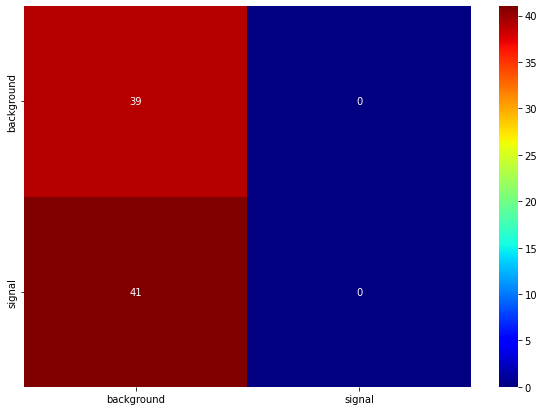

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(reals.flatten(), preds.flatten()), index = ['background', 'signal'],
                  columns = ['background', 'signal'])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.heatmap(df_cm, annot=True, cmap="jet")
plt.show()

# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [ ]:
np.sum(reals.flatten())

359

In [15]:
torch.save(net, './model_save_train_VGG_reduced_time.pth')

In [12]:
net = torch.load('./model_save_train_VGG_reduced_time.pth')


In [ ]:
confusion_matrix(reals.flatten(), preds.flatten())

array([[ 45,  12],
       [  8, 335]], dtype=int64)